# Specific Test II. Lens Finding

**Task**: Build a model classifying the images from \easy directory into lenses using PyTorch or Keras. Evaluate your algorithm on the images from \hard directory; note that only 20% of them have labels available, you can use the rest to train the domain adaptation model or other model of your choice. Pick the most appropriate approach and discuss your strategy.

**Dataset Description**: A dataset comprising images with and without strong lenses. Images in three different filters are available for each object. Description of columns of files containing labels (easy_test.csv and hard_test_cut.csv) is in header.txt. Dataset can be found in this link **[dataset](https://drive.google.com/file/d/1K5cJbC9rfTuUIYVF-AL0NKXNvpXbH9-A/view?usp=sharing)**

In [1]:
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
from torchvision import models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from torch.utils.data import Dataset
import pandas as pd
from torch.utils.data import DataLoader
from torchvision.models import ResNet50_Weights
from astropy.io import fits
from torch.autograd import Function



cudnn.benchmark = True
plt.ion()   # interactive mode|

## Build custom dataset and dataloader

In this challenge we want to use unlabelled data in validation dataset for domain adaptation to increase accuracy. So we will create 3 kind of dataset. 
1. Dataset for training
2. Dataset for domain adaptation training
3. Dataset for validation

In [2]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class CustomTrainingDataset(Dataset):
    def __init__(self, root_dir:int, label_path:str, transform=transforms.ToTensor()):
        self.root_dir = root_dir
        self.transform = transform
        self.label_file = pd.read_csv(label_path).sort_values(by='ID')
        self.labels = self.label_file['no_source'].to_numpy()  
        self.classes = list(set(self.labels))
        self.images_path = sorted(os.listdir(root_dir))

    def __len__(self):
        return len(self.images_path)

    def __getitem__(self, idx):
        image_path = os.path.join(self.root_dir, self.images_path[idx]) 
        with fits.open(image_path) as hdul:
            image = hdul[0].data
        label = torch.tensor(self.labels[idx], device=DEVICE)
        image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
        image = image.to(DEVICE)
        return image, label

In [3]:
class CustomDomainAdaptationDataset(Dataset):
    def __init__(self, root_dir:int, label_path:str, transform=transforms.ToTensor()):
        self.root_dir = root_dir
        self.transform = transform
        self.label_file = pd.read_csv(label_path).sort_values(by='ID')
        # All data that can be used for validation and domain adaptation
        self.all_images_path = sorted(os.listdir(root_dir))
        # Only data that we use for domain adaptation
        self.da_images_path = self._select_domain_adaptation_data()
        # We don't use this label in the training
        self.labels = np.zeros(len(self.da_images_path))

    def _select_domain_adaptation_data(self):
        data_for_validation = set(self.label_file['ID'])
        image_prefix = self.all_images_path[0][:11]
        all_images_data = set([int(file.split('-')[1].split('.')[0]) for file in self.all_images_path])
        data_for_domain_adaptation = sorted(list(all_images_data - data_for_validation))
        return ["{}-{}.fits".format(image_prefix,file_id) for file_id in data_for_domain_adaptation]

    def __len__(self):
        return len(self.da_images_path)
    
    def __getitem__(self, idx):
        image_path = os.path.join(self.root_dir, self.da_images_path[idx]) 
        with fits.open(image_path) as hdul:
            image = hdul[0].data
        label = torch.tensor(self.labels[idx], device=DEVICE)
        image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
        image = image.to(DEVICE)
        return image, label

In [5]:
class CustomValidationDataset(Dataset):
    def __init__(self, root_dir:int, label_path:str, transform=transforms.ToTensor()):
        self.root_dir = root_dir
        self.transform = transform
        self.label_file = pd.read_csv(label_path).sort_values(by='ID')
        self.labels = self.label_file['no_source'].to_numpy()
        # All data that can be used for validation and domain adaptation
        self.all_images_path = sorted(os.listdir(root_dir))
        # Only data that we use for validation
        self.val_images_path = self._select_validation_data()

    def _select_validation_data(self):
        data_for_validation = list(self.label_file['ID'])
        image_prefix = self.all_images_path[0][:11]
        return ["{}-{}.fits".format(image_prefix,file_id) for file_id in data_for_validation]

    def __len__(self):
        return len(self.val_images_path)
    
    def __getitem__(self, idx):
        image_path = os.path.join(self.root_dir, self.val_images_path[idx]) 
        with fits.open(image_path) as hdul:
            image = hdul[0].data
        label = torch.tensor(self.labels[idx], device=DEVICE)
        image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
        image = image.to(DEVICE)
        return image, label

In [6]:
BATCH_SIZE=10


class MinMaxNormalization(object):
    def __call__(self, tensor):
        min_val = torch.min(tensor)
        max_val = torch.max(tensor)
        return (tensor - min_val) / (max_val - min_val)
    
# Data augmentation and normalization for training
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        MinMaxNormalization()
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        MinMaxNormalization()
    ]),
    'da': transforms.Compose([
        transforms.ToTensor(),
        MinMaxNormalization()
    ]),
}


train_dataset = CustomTrainingDataset("challenge_2_ML4Science/lens_finding/easy/Band1","challenge_2_ML4Science\lens_finding\easy_test.csv",data_transforms['train'])
train_dataloader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)

da_dataset = CustomDomainAdaptationDataset("challenge_2_ML4Science/lens_finding/hard/Band1", "challenge_2_ML4Science\lens_finding\hard_test_cut.csv",data_transforms['da'])
da_dataloader = DataLoader(da_dataset,batch_size=BATCH_SIZE)

val_dataset = CustomValidationDataset("challenge_2_ML4Science/lens_finding/hard/Band1", "challenge_2_ML4Science\lens_finding\hard_test_cut.csv",data_transforms['val'])
val_dataloader = DataLoader(val_dataset,batch_size=BATCH_SIZE)

dataset_sizes = {
    "train":len(train_dataset),
    "val": len(val_dataset),
    "da": len(da_dataset)
    }

Feature batch shape: torch.Size([10, 1, 101, 101])
Labels batch shape: torch.Size([10])
0


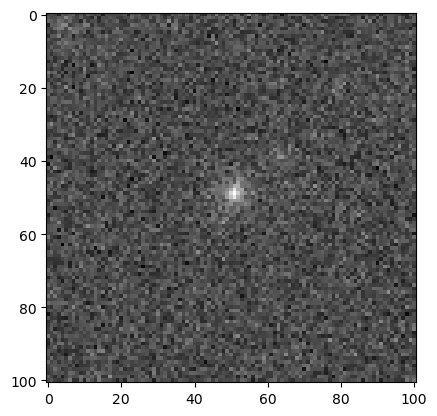

Label: 1


In [7]:
# Display image and label.

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
print(img.get_device())
img = img.cpu().numpy()

label = train_labels[0]
plt.imshow(img,cmap='gray')
plt.show()
print(f"Label: {label}")

## Build Neural Network Architecture

The neural network is based on restnet50 architecture, but a convolutional layer is added in the beginning of the layer to handle single kernel image data. In this model, we remove the fully connected layer in restnet and replace it with sequential linear layer. The domain adaptation technique that we will use is "Domain adversarial" training (based on Ganin et al. 2015)

![Domain adversarial training architecture](./img/ganin_da.png "Domain adversarial network").

In [8]:
class GradientReversalFn(Function):
    @staticmethod
    def forward(ctx, x, lambda_const):
        # Store context for backprop
        ctx.lambda_const = lambda_const
        
        # Forward pass is a no-op
        return x

    @staticmethod
    def backward(ctx, grad_output):
        # grad_output is dL/dx (since our forward's output was x)
        
        # Backward pass is just to apply -λ to the gradient
        # This will become the new dL/dx in the previous parts of the network
        # output =  - ctx.lambda_const * grad_output
        output =  - ctx.lambda_const * grad_output

        # Must return number of inputs to forward()
        return output, None

In [9]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.conv1 = nn.Conv2d(1, 3, 3)
        # Load the pre-trained ResNet50 model
        resnet50 = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        # Remove the fully connected layer (fc) from the model
        self.resnet50_without_fc = torch.nn.Sequential(*list(resnet50.children())[:-1])
        num_ftrs = resnet50.fc.in_features
        self.class_classifier = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 2)
        )
        self.domain_classifier = nn.Sequential(
            nn.Linear(num_ftrs,512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Linear(512,64),
            nn.ReLU(),
            nn.Linear(64,2)
        )


    def forward(self, x, lambda_param=1.0):
        x = self.conv1(x)
        
        x = self.resnet50_without_fc(x)
        x = self.flatten(x)
        features_grl = GradientReversalFn.apply(x, lambda_param)
        # classify on regular features
        class_pred = self.class_classifier(x)
        # classify on features after GRL
        domain_pred = self.domain_classifier(features_grl)
        return class_pred, domain_pred

In [10]:
# Create the model
model = NeuralNetwork()
model.to(DEVICE)

# Test the model forward method on input data
train_features, train_labels = next(iter(train_dataloader))
with torch.no_grad():
    out1,out2 = model(train_features)

In [11]:
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (conv1): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1))
  (resnet50_without_fc): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True

In [12]:
print(out1.shape)
print(out2.shape)

torch.Size([10, 2])
torch.Size([10, 2])


## Define function to training the model

For the purpose of capturing the best model's weight, we will test our training result for every epoch using validation data. then we will save the weight that has the best accuracy

In [13]:
def train_model(model, optimizer, loss_fn_class, loss_fn_domain, scheduler, num_epochs=25):
    since = time.time()
    # We'll train the same number of batches from both domain adaptation and train datasets
    max_batches = min(len(train_dataloader), len(da_dataloader))

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(1,num_epochs+1):
            print(f'Epoch {epoch}/{num_epochs}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train','val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                size =  max_batches if phase == 'train' else len(val_dataloader.dataset)
                running_loss = 0.0
                running_corrects = 0
                
                dl_train_iter = iter(train_dataloader)
                dl_da_iter = iter(da_dataloader)

                # Looping for training phase
                if phase == 'train':
                    for batch_idx in range(max_batches):
                        # Calculate training progress and GRL λ
                        p = float(batch_idx + epoch * max_batches) / (num_epochs * max_batches)
                        λ = 2. / (1. + np.exp(-10 * p)) - 1

                        # === Train on source domain ===
                        X_train, y_train = next(dl_train_iter)
                        # generate source domain labels: 0
                        da_label_on_train_data = torch.zeros(BATCH_SIZE, dtype=torch.long, device=DEVICE) 
                        
                        train_pred, da_pred_on_train_data = model(X_train, λ)
                        # source classification loss
                        loss_train = loss_fn_class(train_pred, y_train)
                        # source domain loss (via GRL)
           
                        loss_da_on_train_data = loss_fn_domain(da_pred_on_train_data, da_label_on_train_data)

                        # === Train on target domain ===
                        X_da, _ = next(dl_da_iter) # Note: ignoring target domain class labels!
                        # generate target domain labels: 1
                        da_label_on_da_data = torch.ones(BATCH_SIZE, dtype=torch.long, device=DEVICE) 

                        _, da_pred_on_da_data = model(X_da, λ)
                        # target domain loss (via GRL)
                        loss_da_on_da_data = loss_fn_domain(da_pred_on_da_data, da_label_on_da_data)

                        # === Optimize
                        current_loss_training_total = loss_da_on_da_data + loss_da_on_train_data + loss_train
                        optimizer.zero_grad()
                        current_loss_training_total.backward()
                        optimizer.step()
                        current =  batch_idx * BATCH_SIZE + len(X_train)
                        if batch_idx % 100 == 0:
                            print(f"Current {phase} loss: {current_loss_training_total:>7f}  [{current:>5d}/{size:>5d}]")
                    scheduler.step()

                # Iterate over source data.
                if phase == 'val':
                    for batch, (inputs, labels) in enumerate(val_dataloader):
                        # zero the parameter gradients
                        labels = labels.long()
                        optimizer.zero_grad()

                        # forward
                        with torch.set_grad_enabled(False):
                            # Ignoring domain adaptation layer prediction
                            val_pred, _ = model(inputs)
                            _, pred_labels = torch.max(val_pred, 1)
                            loss = loss_fn_class(val_pred, labels)

                        # statistics
                        current_loss = loss.item()
                        current =  batch * BATCH_SIZE + len(inputs)
                        running_loss += loss.item() * inputs.size(0)
                        running_corrects += torch.sum(pred_labels == labels.data)
                    
                        if batch % 100 == 0:
                            print(f"Current {phase} loss: {current_loss:>7f}  [{current:>5d}/{size:>5d}]")

                    epoch_loss = running_loss / dataset_sizes[phase]
                    epoch_acc = running_corrects.double() / dataset_sizes[phase]
                    print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                    # deep copy the model
                    if epoch_acc > best_acc:
                        best_acc = epoch_acc
                        torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [14]:
lr = 1e-3
# Setup optimizer as usual
optimizer = torch.optim.SGD(model.parameters(),lr=lr,momentum=0.9)

# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Two loss functions this time (can generally be different)
loss_fn_class = nn.CrossEntropyLoss()
loss_fn_domain = nn.CrossEntropyLoss()

In [35]:
model_ft = train_model(model, optimizer , loss_fn_class, loss_fn_domain, exp_lr_scheduler,
                       num_epochs=25)

Epoch 1/25
----------
Current train loss: 2.161128  [   10/ 1040]
Current train loss: 2.037202  [ 1010/ 1040]
Current train loss: 1.841339  [ 2010/ 1040]
Current train loss: 1.686159  [ 3010/ 1040]
Current train loss: 1.756613  [ 4010/ 1040]
Current train loss: 1.837715  [ 5010/ 1040]
Current train loss: 1.608379  [ 6010/ 1040]
Current train loss: 1.747591  [ 7010/ 1040]
Current train loss: 1.463318  [ 8010/ 1040]
Current train loss: 1.445977  [ 9010/ 1040]
Current train loss: 1.628920  [10010/ 1040]
Current val loss: 0.606566  [   10/ 2600]
Current val loss: 0.177481  [ 1010/ 2600]
Current val loss: 0.032137  [ 2010/ 2600]
val Loss: 0.1528 Acc: 0.9246

Epoch 2/25
----------
Current train loss: 1.538453  [   10/ 1040]
Current train loss: 1.561167  [ 1010/ 1040]
Current train loss: 1.499597  [ 2010/ 1040]
Current train loss: 1.485255  [ 3010/ 1040]
Current train loss: 1.462627  [ 4010/ 1040]
Current train loss: 1.394395  [ 5010/ 1040]
Current train loss: 1.484139  [ 6010/ 1040]
Current 

In [15]:
# torch.save(model.state_dict(), 'model_weights_challenge2_with_da_train2.pth')

## Load trained model and plot the prediction on validation dataset

In [15]:
model.load_state_dict(torch.load('model_weights_challenge2_with_da.pth'))

<All keys matched successfully>

In [16]:
def plot_model_prediction(batch_images, actual_label, predicted_label):
    num_images = batch_images.shape[0]

    # Create a grid of subplots
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()

    for i in range(num_images):
        # Extract the image from the batch_images
        image = batch_images[i, 0]  # Assuming grayscale images
        # Plot the image
        axes[i].imshow(image, cmap='gray')  # Assuming grayscale images
        axes[i].set_title("pred: {}, actual: {}".format(predicted_label[i],actual_label[i]))
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

idx_to_class = {
    0: "lensed",
    1: "no lense"
}

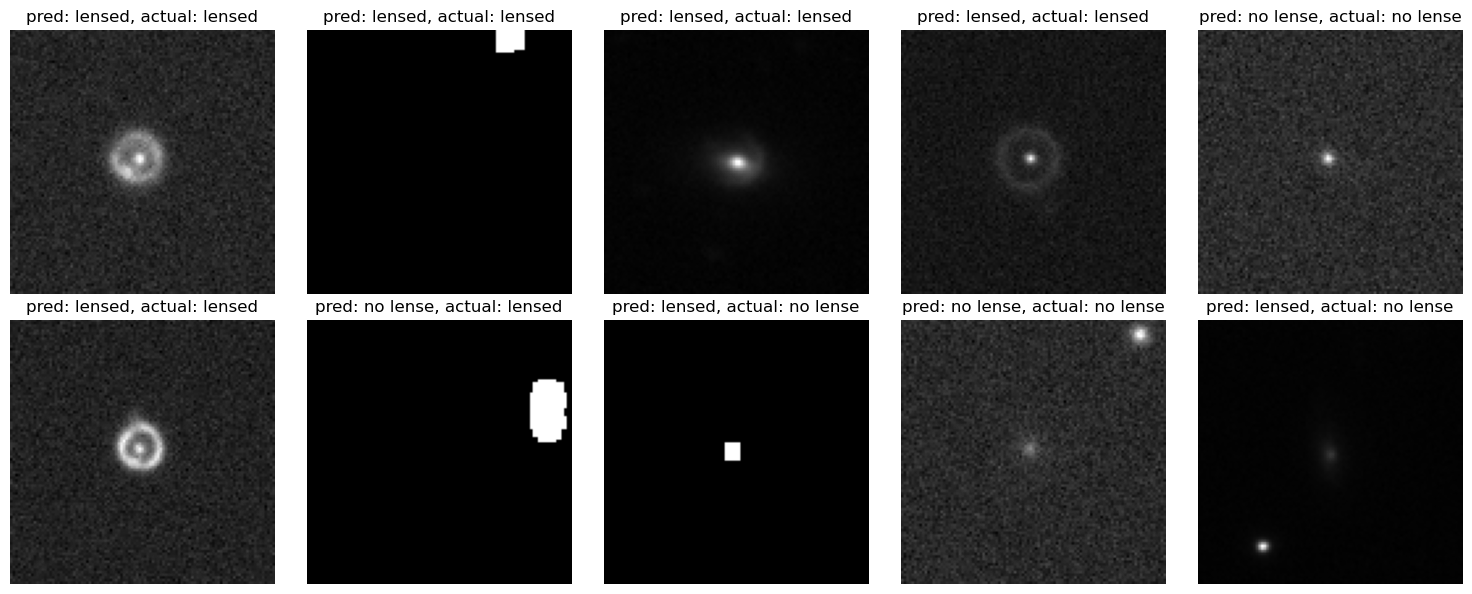

In [17]:
model.eval()
with torch.no_grad():
    inputs, label = next(iter(val_dataloader))
    class_output, _ = model(inputs)
    _, preds = torch.max(class_output, 1)

plot_model_prediction(inputs.cpu(),
                      [idx_to_class[idx] for idx in label.cpu().numpy()], 
                      [idx_to_class[idx] for idx in preds.cpu().numpy()])

## Load trained model and plot the prediction on validation dataset

In [18]:
actual_test_labels = []
predicted_test_labels = []
for batch, (test_data, test_label) in enumerate(val_dataloader):
    model.eval()
    with torch.no_grad():
        prediction_score, _ = model(test_data)
        _, prediction_output = torch.max(prediction_score,1)
        predicted_test_labels.extend(prediction_output.cpu().numpy())
    actual_test_labels.extend(test_label.cpu().numpy())

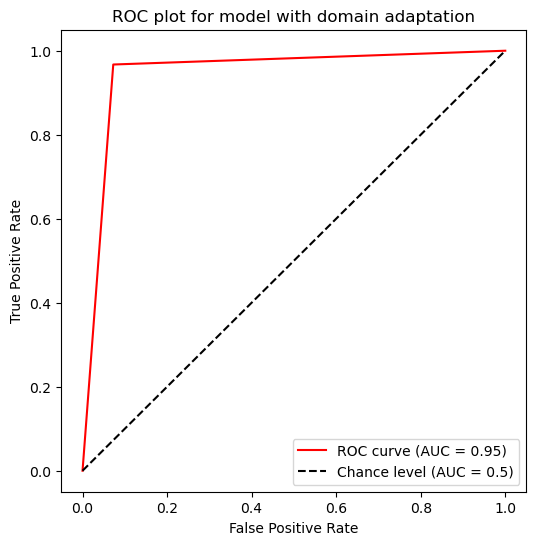

In [19]:
from itertools import cycle

from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots(figsize=(6, 6))
colors = cycle(["aqua", "darkorange", "cornflowerblue"])
RocCurveDisplay.from_predictions(
    actual_test_labels,
    predicted_test_labels,
    name=f"ROC curve",
    color='red',
    ax=ax,
    plot_chance_level=True,
)

_ = ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="ROC plot for model with domain adaptation",
)